<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LGBMR" data-toc-modified-id="LGBMR-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBMR</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install catboost --quiet

import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [3]:
try:
  df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
  df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
print(df.info(), df.head(5), df.tail(5),df.describe(), sep='\n\n')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

                     num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


Пропуски отсутствуют, аномалии отсутсвуют, с данными все в порядке.

In [5]:
# рресемплируем данные по часу
df = df.resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [6]:
# Создадим функцию для добавления признаков
def make_features(dt):
    data = dt.copy()
    data['dayofweek'] = data.index.dayofweek
    data['lag_1_hour'] = data['num_orders'].shift(1)
    data['lag_1_day'] = data['num_orders'].shift(24)
    data['lag_1_week'] = data['num_orders'].shift(168)

    data['rolling_mean_week'] = data['num_orders'].shift().rolling(168).mean()

    data['rolling_mean_day'] = data['num_orders'].shift().rolling(24).mean()

    data.dropna(inplace = True)

    return data

In [7]:
# Применим функцию к нашему датафрейму
df_new = make_features(df)

**Вывод:** загружены и изучены данные, проведено ресемплирование данных и добавлены новые признаки.

## Анализ

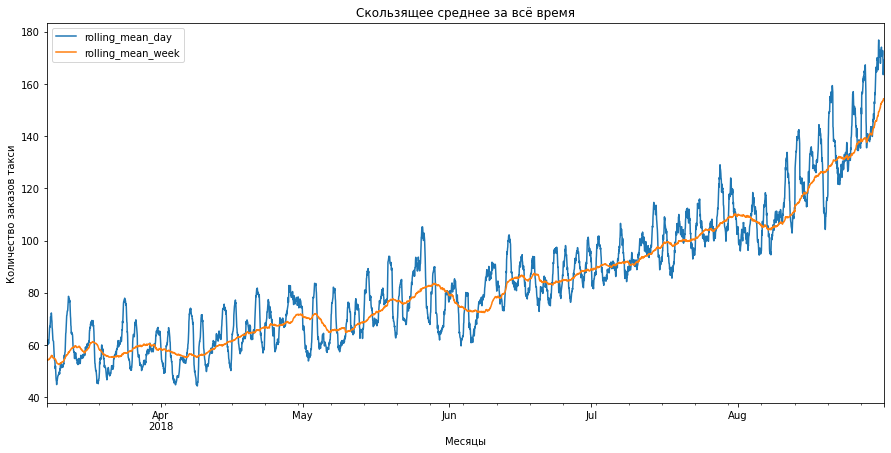

In [8]:
# построим график скользящего среднего за все время
df_new.loc[:, ['rolling_mean_day', 'rolling_mean_week']].plot(figsize=(15,7))

plt.xlabel("Месяцы")
plt.ylabel("Количество заказов такси")
plt.title('Скользящее среднее за всё время')
plt.show()

По графику можно сказать, что среднее значение количества заказов растет, а значит увеличивается тренд.

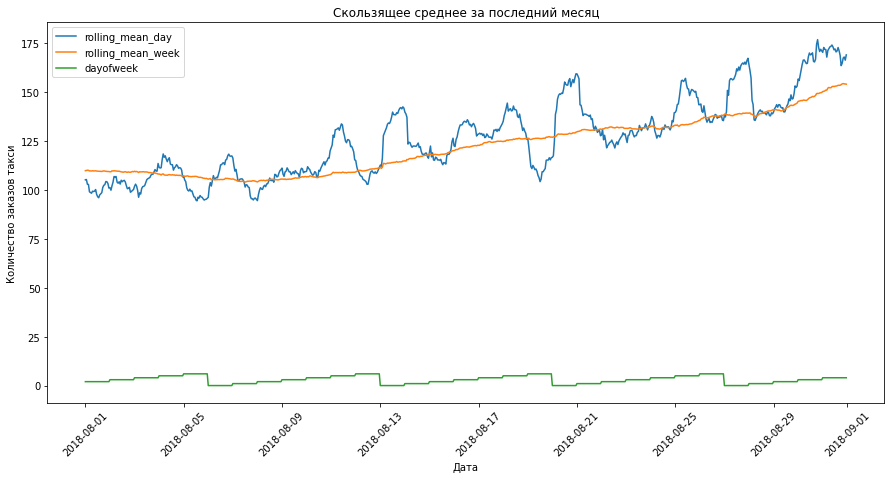

In [9]:
# построим график скользящего среднего за последний месяц
df_new_lastmonth = df_new.loc['2018-08-01':'2018-08-31', :]

plt.figure(figsize=(15, 7))
plt.plot(df_new_lastmonth.index, df_new_lastmonth.loc[:,['rolling_mean_day', 'rolling_mean_week', 'dayofweek']])
plt.legend(labels=['rolling_mean_day', 'rolling_mean_week', 'dayofweek'])
plt.xticks(rotation=45)

plt.xlabel("Дата")
plt.ylabel("Количество заказов такси")
plt.title('Скользящее среднее за последний месяц')

plt.show()

По dayofweek видны колебания.

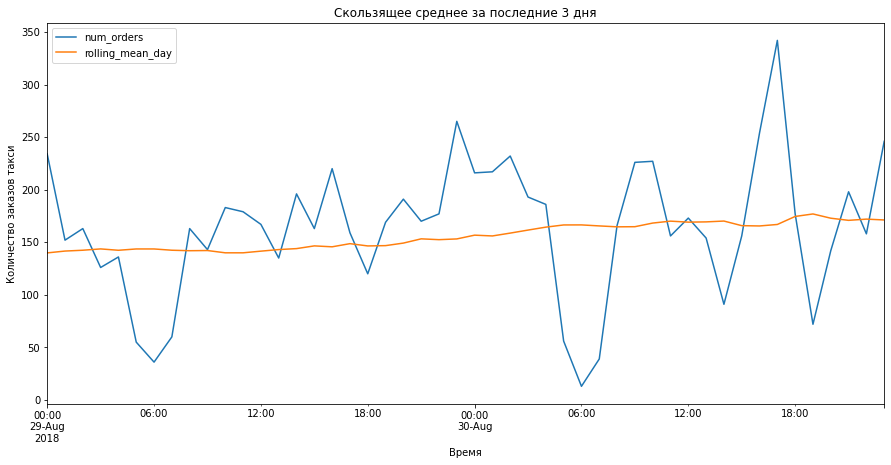

In [10]:
# построим график скользящего среднего за последние 2 дня
df_new.loc['2018-08-29':'2018-08-30', ['num_orders', 'rolling_mean_day']].plot(figsize=(15,7))

plt.xlabel("Время")
plt.ylabel("Количество заказов такси")
plt.title('Скользящее среднее за последние 3 дня')
plt.show()

Наблюдаетс зависимость количества заказов от времени суток: на 06:00 прихдится минимум заказов, тогда как их пик ~18:00.

Text(51.75, 0.5, 'Количество заказов такси')

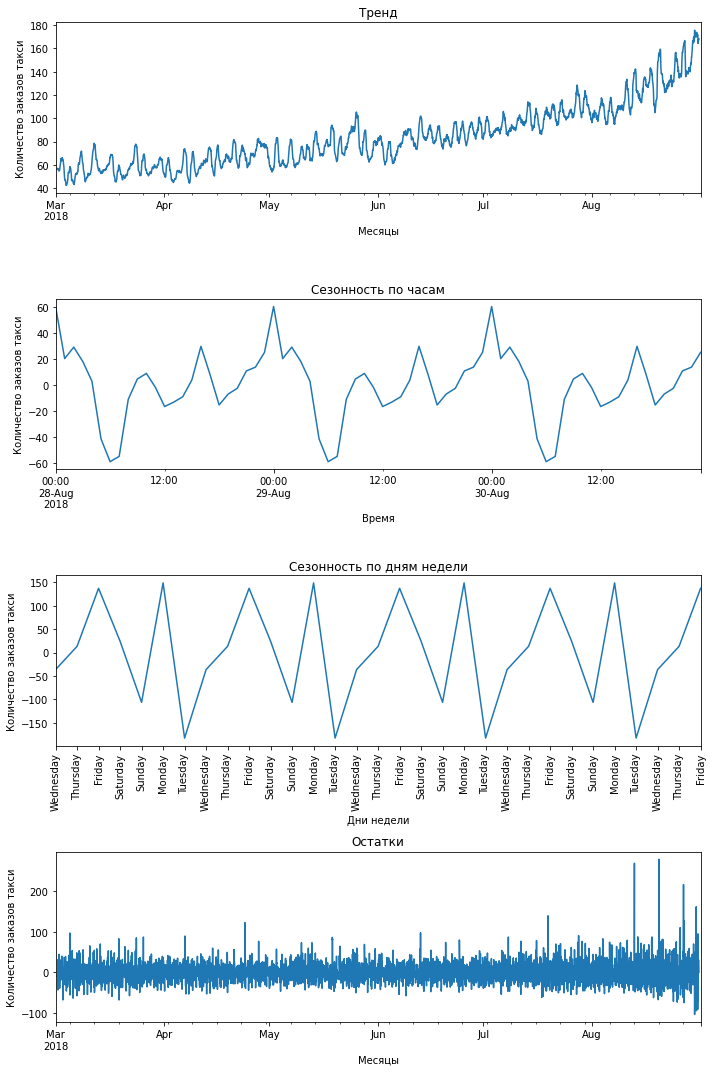

In [11]:
# декомпозиция данных
decomposed = seasonal_decompose(df)

# ресемплирование данных по дням
df_day = df.resample('1D').sum()
decomposed_day = seasonal_decompose(df_day)

plt.figure(figsize=(10, 15))

# тренд
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Месяцы")
plt.ylabel("Количество заказов такси")

# сезонность в часах
plt.subplot(412)
decomposed.seasonal['2018-08-28':'2018-08-30'].plot(ax=plt.gca())
plt.title('Сезонность по часам')
plt.xlabel("Время")
plt.ylabel("Количество заказов такси")

# сезонность в днях
plt.subplot(413)
d_day = decomposed_day.seasonal['2018-08-01':'2018-08-31']
d_day.plot(ax=plt.gca())
plt.xticks(ticks= d_day.index, labels = d_day.index.day_name(), rotation=90)
plt.xlabel("dayofweek")
plt.title('Сезонность по дням недели')
plt.xlabel("Дни недели")
plt.ylabel("Количество заказов такси")

# остатки
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()
plt.xlabel("Месяцы")
plt.ylabel("Количество заказов такси")

Тренд: возрастает. <br>
Сезонность по дням недели: снижена по вторникам и воскресеньям, на пике по понедельникам и пятницам.<br>
Сезонность по часам: снижена в 6 утра, пик в 24 часа.<br>
Остатки:возрастает к концу последнего месяца.

**Вывод:** проаналированы данные, выявились следующие закономерности: <br>
- Тренд: возрастает. <br>
- Сезонность по дням недели: снижена по вторникам и воскресеньям, на пике по понедельникам и пятницам.<br>
- Сезонность по часам: снижена в 6 утра, пик в 24 часа.<br>
- Остатки:возрастает к концу последнего месяца.

In [12]:
result = adfuller(df['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


In [16]:
result = adfuller(df['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

for key, value in result[4].items():
    print(f'Уровень значимости - {key}')
    if result[0] < result[4][key]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Уровень значимости - 1%
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
Уровень значимости - 5%
Нулевая гипотеза отвергнута – Временной ряд стационарен
Уровень значимости - 10%
Нулевая гипотеза отвергнута – Временной ряд стационарен


## Обучение

In [ ]:
# разобьем данные на выборки
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### LGBMR

In [ ]:
%%time
mcv = TimeSeriesSplit(n_splits=3)

CPU times: user 27 µs, sys: 5 µs, total: 32 µs
Wall time: 35.5 µs


In [ ]:
%%time
start_lgbr = time.time()

cat_features = df_new.select_dtypes(include=np.object).columns.tolist()
df_new[cat_features] = df_new[cat_features].astype('category')

param_lgbr = {'learning_rate': [0.05, 0.1], 'n_estimators': [300]}


estimator = lgb.LGBMRegressor(objective='regression',
                              random_state=12345,
                              n_estimators=300)

lgbr = GridSearchCV(estimator=estimator,
                     param_grid=param_lgbr,
                     cv=mcv,
                     n_jobs=-1,
                     scoring='neg_root_mean_squared_error',
                     verbose=1)
lgbr.fit(X_train, y_train, categorical_feature=cat_features)

# Выводим лучшие параметры поиска
print('LGBMRegressor:')
print(f'Лучшие параметры: {lgbr.best_params_}')
lgbr_rmse = lgbr.best_score_*(-1)
print(f'RMSE для лучших параметров:', round(lgbr_rmse, 2))

result_lgbr = time.time() - start_lgbr

Fitting 3 folds for each of 2 candidates, totalling 6 fits
LGBMRegressor:
Лучшие параметры: {'learning_rate': 0.05, 'n_estimators': 300}
RMSE для лучших параметров: 26.72
CPU times: user 1.17 s, sys: 73 ms, total: 1.25 s
Wall time: 8.26 s


### CatBoostRegressor

In [ ]:
%%time
start_cbr = time.time()

param_cbr = {'learning_rate': [0.1, 0.03], 'depth': [6, 10]}

estimator = CatBoostRegressor(loss_function="RMSE", iterations=100, random_state=12345, cat_features=cat_features)

cbr = GridSearchCV(estimator=estimator,
                     param_grid=param_cbr,
                     cv=mcv,
                     n_jobs=-1,
                     scoring='neg_root_mean_squared_error',
                     verbose=10)
cbr.fit(X_train, y_train, verbose=30)

print('CatBoostRegressor:')
print(f'Лучшие параметры: {cbr.best_params_}')
cbr_rmse = cbr.best_score_*(-1)
print(f'RMSE для лучших параметров:', round(cbr_rmse, 2))

result_cbr = time.time() - start_cbr

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0:	learn: 36.6240562	total: 50.2ms	remaining: 4.97s
30:	learn: 21.8908063	total: 116ms	remaining: 259ms
60:	learn: 21.1397595	total: 171ms	remaining: 109ms
90:	learn: 20.5569499	total: 251ms	remaining: 24.8ms
99:	learn: 20.4385514	total: 267ms	remaining: 0us
CatBoostRegressor:
Лучшие параметры: {'depth': 6, 'learning_rate': 0.1}
RMSE для лучших параметров: 24.3
CPU times: user 408 ms, sys: 34.2 ms, total: 442 ms
Wall time: 12.8 s


### RandomForestRegressor

In [ ]:
%%time
start_rf = time.time()

mcv = TimeSeriesSplit(n_splits=3)
param_rf = {'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 4, 5, 6]
}

estimator = RandomForestRegressor(n_jobs=-1, random_state=12345)

rf = GridSearchCV(estimator = estimator,
                  param_grid= param_rf,
                  cv = mcv,
                  n_jobs= -1,
                  scoring = 'neg_root_mean_squared_error',
                  verbose=10)

rf.fit(X_train,y_train)

print('RandomForestRegressor')
print(f'Лучшие параметры: {rf.best_params_}')

rf_rmse = rf.best_score_*(-1)
print(f'RMSE для лучших параметров:', round(rf_rmse, 2))

result_rf = time.time() - start_rf

Fitting 3 folds for each of 15 candidates, totalling 45 fits
RandomForestRegressor
Лучшие параметры: {'max_depth': 5, 'n_estimators': 200}
RMSE для лучших параметров: 24.6
CPU times: user 1.76 s, sys: 49.5 ms, total: 1.81 s
Wall time: 19.6 s


### Вывод
Были обучены три модели: LGBMR, CatBoostRegressor и RandomForestRegressor. Наилучшую метрика качества ~15.73 показала модель CatBoostRegressor. Сводная таблица представлена ниже:

In [ ]:
df_res = pd.DataFrame({'RMSE': [lgbr_rmse, cbr_rmse, rf_rmse], 'Time, s': [result_lgbr, result_cbr, result_rf]},
                      index = ['LGBMRegressor', 'CatBoostRegressor', 'RandomForestRegressor'])
df_res

,RMSE,"Time, s"
LGBMRegressor,26.717757,8.255182
CatBoostRegressor,24.296589,12.775749
RandomForestRegressor,24.595645,19.598791


## Тестирование

Проведем тестирование на модели, показавшей наилучшее качество RMSE, - CatBoostRegressor:

In [ ]:
prediction_CBR = cbr.predict(X_test)
print('RMSE = ', round(mean_squared_error(y_test, prediction_CBR)**0.5,2))

RMSE =  41.84


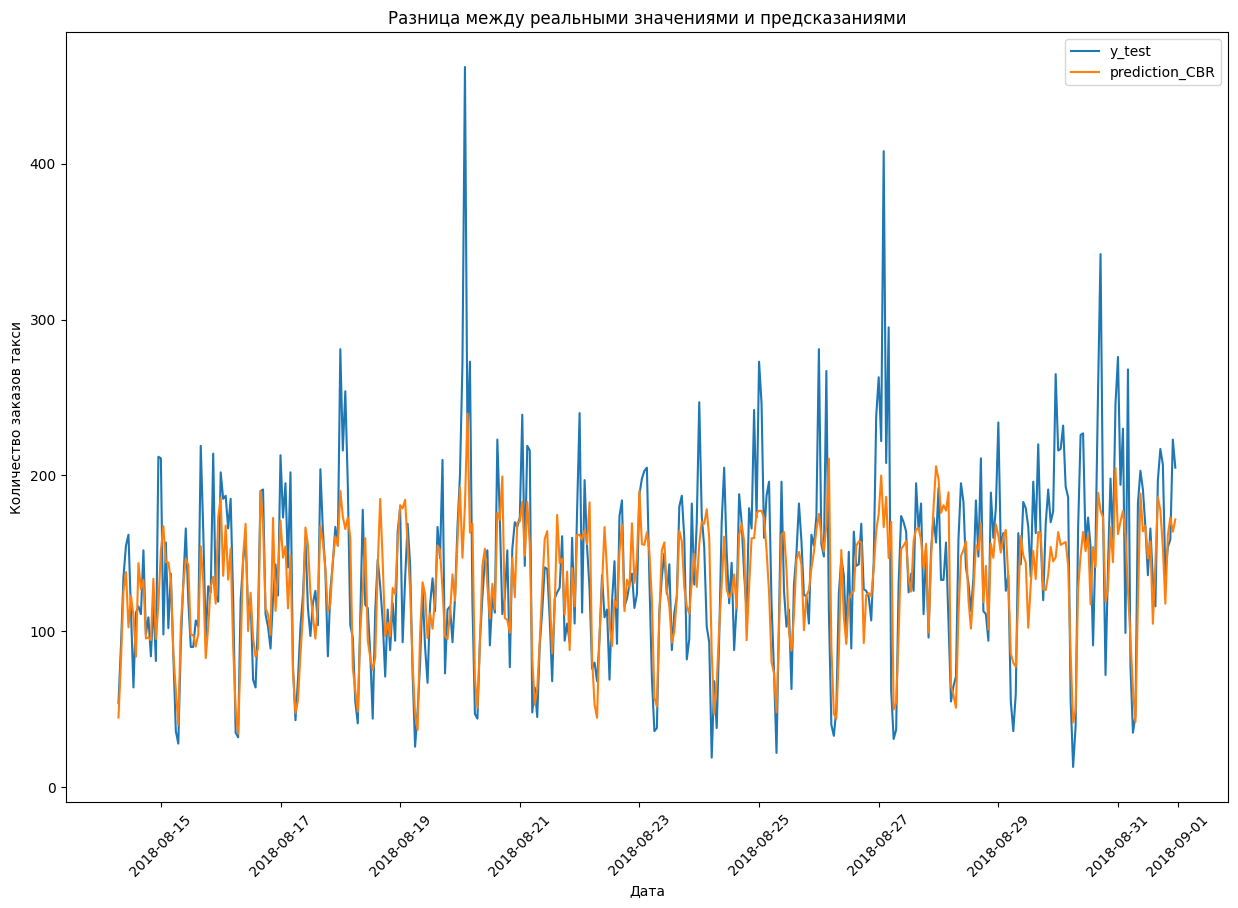

In [ ]:
# посмотрим на грифке разницу между реальными значениями и предсказаниями для теста
plt.figure(figsize=(15, 10))
plt.plot(y_test.index, y_test, label = 'y_test')
plt.plot(y_test.index, prediction_CBR, label = 'prediction_CBR')
plt.xticks(rotation=45)
plt.xlabel("Дата")
plt.ylabel("Количество заказов такси")
plt.title('Разница между реальными значениями и предсказаниями')
plt.legend()
plt.show()

**Вывод:** получили RMSE на тестовой выборке равной 44.2. Построили график. Можно сказать, что предсказания почти повторяют реальные значения, но они не повторяют их в max и min значениях, что может быть связано с тем, что эти значения - остатки и шумы, которые не связаны с трендом и/или сезонностью.

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
prediction_dummy = dummy_regr.predict(X_test)
print('RMSE = ', round(mean_squared_error(y_test, prediction_dummy)**0.5,2))

RMSE =  84.45


Проверку на адекватность лучшая модель в сравнении с DummyRegressor прошла: 41.84 против 84.45.

## Общий вывод
1. Загрузили данные и ознакомились с ними: всё было в порядке.
2. Проанализировали полученные данные, выявились следующие закономерности: <br>
- Тренд: возрастает. <br>
- Сезонность по дням недели: снижена по вторникам и воскресеньям, на пике по понедельникам и пятницам.<br>
- Сезонность по часам: снижена в 6 утра, пик в 24 часа.<br>
- Остатки:возрастает к концу последнего месяца.
3. Обучили три модели, наилучший RMSE = 15.73 показала модель CatBoostRegressor
4. Прогнали модель по тестовой выборке, RMSE = 44.2. Посмотрели на графике разницу между реальными значениями и прдсказаниями по тестовой выборке.